# Simple approach to clustering S&P 500 stocks

Some boilerplate imports.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Download daily closing prices for each S&P500 security.
Once this is done, fix a timespan (e.g. 3 years) to create a {trading days in 3 years}-dimensional vector for each security. Call this dimension $n$ from now on.
The following step would be to normalize the price of each security over this span. What is the wisest way to normalize?
1. Scale so that each vector has the same norm in $\ell^p$ for some $1 \le p \le \infty$.
2. Moving average normalization over 5, 10, 20, 50, etc. days.
3. A norm as in 1. but with unequal weights applied to different days.
4. Normalization used in El Mehdi's link: https://www.sciencedirect.com/science/article/pii/S1057521923001734

### Pulling the list of tickers from Wikipedia.

In [2]:
# Fetch the list of S&P 500 tickers from Wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
tickers = df['Symbol'].tolist()

### Pulling daily closing prices from Yahoo Finance

Each time series is downloaded as a pandas Series, then stored in a list to be concatenated into a massive table.

The columns are tickers and the rows are dates. We remove any dates with missing data, but I'm sure there's a simple & effective imputation method (e.g. mean of last available and next available closing price).

In [3]:
# Create a list to store individual stock DataFrames
dfs = []

# Download the historical data
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, period='3y')['Adj Close']
        stock_data.name = ticker  # Rename the Series to match the ticker
        dfs.append(stock_data)
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")

# Concatenate all the individual DataFrames
closing_prices = pd.concat(dfs, axis=1)

# Drop rows with any missing values for consistency
closing_prices.dropna(axis=1, inplace=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['BF.B']: Exception("%ticker%: Period '3y' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

## Data preprocessing

### Compute $\ell^2$ norm for each time series, then normalize by this norm

In [4]:
norms = {}
for ticker in closing_prices.columns:
    norms[ticker] = np.linalg.norm(closing_prices[ticker])

Next, we normalize each column in closing_prices. ```np.linalg.norm()``` is what I want.

In [5]:
closing_prices_normalized = closing_prices.copy()
for ticker in closing_prices.columns:
    closing_prices_normalized[ticker] = closing_prices[ticker]/norms[ticker]

For the clustering to work properly, the tickers need to denote rows instead of columns.

In [6]:
df_transposed = closing_prices_normalized.T

### Find most effective number of clusters

In [7]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_transposed)
    wcss.append(kmeans.inertia_)

C:\Users\naman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\naman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


We plot the spread of each cluster, and use the elbow method to find the best ```n_clusters```.

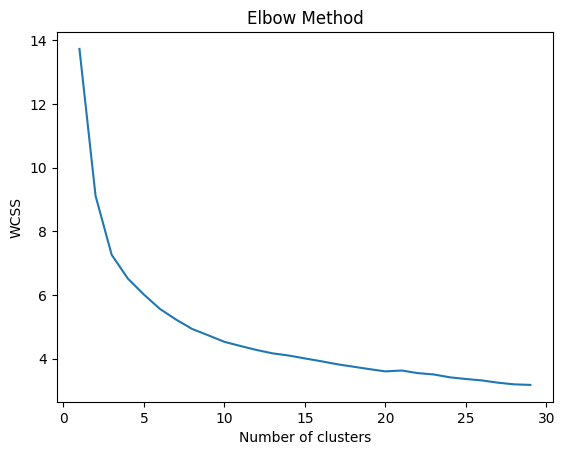

In [9]:
plt.plot(range(1, 30), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Perform the actual clustering.

In [11]:
kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_transposed)

## Add the clusters as a feature so that we may analyze the results

In [12]:
df_transposed['Cluster'] = pred_y

Behold the clusters:

In [14]:
# Checking the tickers in each cluster
for i in range(20):  # 20 is the number of clusters
    print(f"Cluster {i}: \n {df_transposed[df_transposed['Cluster'] == i].index.tolist()}")
    print()

Cluster 0: 
 ['LNT', 'ALL', 'MO', 'AMCR', 'AEE', 'AEP', 'AMGN', 'T', 'BDX', 'BMY', 'CHRW', 'CPB', 'CNC', 'CHD', 'CMS', 'CL', 'CAG', 'STZ', 'CSX', 'DOW', 'DTE', 'DUK', 'ETR', 'EVRG', 'ES', 'FMC', 'HSIC', 'HOLX', 'HRL', 'HST', 'INCY', 'JKHY', 'JNJ', 'K', 'KDP', 'KMB', 'KHC', 'LHX', 'LDOS', 'LYB', 'MKC', 'NRG', 'PKG', 'PNW', 'PPL', 'PG', 'PEG', 'O', 'ROL', 'SYY', 'TMUS', 'TDY', 'VTR', 'WMT', 'WEC', 'WTW', 'XEL']

Cluster 1: 
 ['MMM', 'BALL', 'BAX', 'KMX', 'CTLT', 'CHTR', 'XRAY', 'DIS', 'FIS', 'GPN', 'INTC', 'MKTX', 'MHK', 'QRVO', 'SWKS', 'SWK', 'TFX']

Cluster 2: 
 ['APA', 'CF', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG', 'EQT', 'MRO', 'MOS', 'OXY', 'PXD']

Cluster 3: 
 ['APTV', 'BBWI', 'BIO', 'TECH', 'COF', 'CRL', 'EBAY', 'EPAM', 'MRNA', 'SYF', 'TROW', 'TGT', 'TRMB', 'ZBRA']

Cluster 4: 
 ['AOS', 'ACN', 'GOOGL', 'GOOG', 'AMD', 'AMAT', 'AVY', 'BLK', 'BK', 'BR', 'CARR', 'CBRE', 'CSCO', 'DXCM', 'DFS', 'DOV', 'EMR', 'EFX', 'EXPD', 'FAST', 'BEN', 'GS', 'HD', 'ICE', 'INTU', 'ISRG', 'IQV', 'JCI